## Classifier Model for Succesful Journey Prediction (Original balance approach)
### Team Name : Data Crew

**Contributions:**
* Axel
* Darren
* Ryan
* Taro
* Dan

This notebook was created in order to implement, train and test the classifier model for the prediction of the successful journey of the customers. We are going to make several testing approaches were the seed 2024 is fixed in order to make all the code and the predictions comparable, the testing approaches are:

* Train test split
* Cross Validation in a Stratifield KFold and KFold

Additonally, as we are going to see further in the notebook, the data has a balancing problem and therefore we are going to use the following techniques in order to solve it:

* SMOTE
* ADASYN
* Up Sampling
* Down Sampling

In the cases were the models were trained using the unbalanced data set we are going to use the f1-score in order to measure the performance of the model, and in the cases were the models were trained using the balanced data set we are going to use the accuracy metric instead.

Finally it is worthwhile mentioning that in the case of the XGBoost model we used a hyperparameter optimization in order to find the best hyperparameters for the model with the Bayesian Optimization approach.

Model proposal: 
* XGBoost
* LGBM
* LR
* GB
* ADABoost
* Neural Network
* Random Forest

* Clustering for improving the accuracy of the models by looking at the errors
* Boosting algotithms are performing better
* Causationg learning
* Discover variable
* Analytics
* Markov Chain

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Librarie for Preprocessing (By Us)
from utils import *

# Model Libraries
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Import torch
import torch
import torch.nn as nn

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Optimización de hiperparámetros
import optuna
from skopt import BayesSearchCV
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

# Reporting a progress bar
from tqdm import tqdm

# Downsample majority class
from sklearn.utils import resample

from sklearn.decomposition import PCA 

# standardize the data
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.callbacks import Callback

# %matplotlib inline
# pd.options.mode.chained_assignment = None

#random.seed(2024)
np.random.seed(2024)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

### Data Retrieval

We retrieve the data from the original source, i.e. the one that is uncleaned and unprocessed. Also we retrive the event definition dataset:

In [ ]:
# data = pd.read_csv('../../1. Data/export.csv')   # This is the original data
# data = pd.read_csv('../../1. Data/smaller_sample.csv')  # This is a smaller sample
# event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')  # This is the event dictionary

#### **-> Execute only if working with the original dataset**

As the original dataset does not have some already-merged variables then we have to manually do it. This takes approximately 31 secs.

In [ ]:
# event_defs.drop(columns=['event_name'], inplace=True)
# event_defs.rename(columns={'event_definition_id':'ed_id'}, inplace=True)
# data = pd.merge(data, event_defs, on='ed_id', how='left')
# event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

#### **-> Execute only if working with the sample dataset**

Then we call the **get_classification_dataset** function with *n_events = $5$* (this parameter could be changed everytime and depends only in the number of sequential events we would like to consider in the last **first_n_events** column). This takes approx **2:07** mins to run (using the smaller_sample data set)

In [ ]:
# number_events_fixed = 20
# col_name = 'first_' + str(number_events_fixed) +'_events'

# df = get_classification_dataset(data, event_defs, n_events=number_events_fixed)
# df.reindex(sorted(df.columns), axis=1)

Therefore we reset the index and assigned the current index (which are the cust_ids as a new column)

In [ ]:
# cust_ids = df.index
# cust_ids = [x[0] for x in cust_ids]
# df.reset_index(drop=True, inplace=True)
# df['customer_id'] = cust_ids
# df.head()

#### **-> Execute only if working with the original already-preprocessed dataset**

This option was not considered in the beginning as the data set that we are reading is the dataset that it was supposed to be returned by the code in the section **-> Execute only if working with the original dataset**, but due to a time consuming issue, we ran that section once and saved the dataset in a csv file, which is the file we are reading in this section.

In [ ]:
## DARREN RECOMMENDATION OF CODE

class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def vec_to_list(event_list):
    event_list = event_list.replace('[', '').replace(']', '').split()
    event_list = [int(float(x)) for x in event_list]
    return event_list

def preprocessing_steps_embedding(data):
    df = data.copy()
    df = df.drop(columns=['Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    df = df.astype({col: 'float' for col in df.columns[:-2]})
    
    df = df.dropna(axis=0)


    events = df['first_20_events'].apply(vec_to_list)
    events = torch.tensor(events.to_list()).float()
    events_emb = Embedding(5, 20)
    events = events_emb(events)
    event_pd = pd.DataFrame(events.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])

    time = df['time_since_last_event'].apply(vec_to_list)
    time = torch.tensor(time.to_list()).float()
    time_emb = Embedding(5, 20)
    time = time_emb(time)
    time_pd = pd.DataFrame(time.detach().numpy(), columns=[f'time_{i}' for i in range(5)])
    df = pd.concat([df, event_pd, time_pd], axis=1)
    df = df.drop(columns=['first_20_events', 'time_since_last_event'])


    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target

# Read in preprocessed original dataset
#df = pd.read_csv('../../1. Data/export_n_20.csv')

# Preprocess
#ori_data, ori_target, df, target = preprocessing_steps_embedding(df)

In [ ]:
# Reading the dataset
df = pd.read_csv('../../1. Data/export_n_20.csv').drop(columns=['Unnamed: 1'])
df.reindex(sorted(df.columns), axis=1)
df.head()

As this data set was stored as a **.csv** file, the last two columns were stored as objects and therefore are readed as str type, so we have to convert them to a list or array type.

In [ ]:
# We set this parameters for future interactions with these features
number_events_fixed = 20
col_name = 'first_' + str(number_events_fixed) +'_events'

result = []
for item in list(df[col_name]):
    numbers = [int(num) for num in item.replace('[', '').replace(']', '').split()]
    #numbers += [0] * (number_events_fixed - len(numbers))    
    result.append(numbers)
    
result2 = []
for item in list(df['time_since_last_event']):
    numbers = [float(num) for num in item.replace('[', '').replace(']', '').split()]
    #numbers += [0] * (number_events_fixed - len(numbers))    
    result2.append(numbers)
    
df[col_name] = result
df['time_since_last_event'] = result2

### Filtering the customers by number of events (No longer needed as all have exactly the same length of sequences)

This was achieved by adding zeros in the events sequences that were shorter than the longest one (20).

In [ ]:
# number_events_fixed = 20
# col_name = 'first_' + str(number_events_fixed) +'_events'
# lengths = df[col_name].apply(lambda x: len(x))
# idxs = lengths[lengths == number_events_fixed].index
# df_selected = df.loc[idxs]

### Dropping some columns 

The following columns are being dropped because while training the models we realized that all of them introduced some kind of bias in the predictions, and therefore we decided to drop them in order to have a more general model and mostly because the model was intended to be used in the early stages of the journey of the customer.

* max_milestone
* downpayment_cleared
* first_purchase
* downpayment_received
* account_activitation

In [ ]:
# Saving the customer id's
cust_ids_saved = df['customer_id']

In [ ]:
# Dropping the cols
df.drop(columns=['max_milestone', 'downpayment_cleared', 'first_purchase', 'downpayment_received', 'account_activitation', 'customer_id'], inplace=True)
df.head()

### Changing the boolean columns from 0 to 1

The boolean columns are being changed from 0 to 1 in order to have a more consistent dataset.

In [ ]:
# Setting float values for all the columns except the last 2
df = df.astype({col: 'float' for col in df.columns[:-2]})
df.head()

### Features Added to the dataset (late update)

To see if there is any improvement in the models. This was a late and an experimental update.

* This new feature is the sum (seconds) of all the time spent in the first 20 events.

In [ ]:
df['total_time_spent'] = df['time_since_last_event'].apply(lambda x: np.sum(x))

* The following new features are statistical features such as mean, standard deviation, maximum of the time spent in the first 20 events. (This columns are added in approximately 50 seconds)

In [ ]:
df['time_mean'] = df['time_since_last_event'].apply(lambda x: np.mean(x))
print('mean added')
df['time_std'] = df['time_since_last_event'].apply(lambda x: np.std(x))
print('std added')
df['time_max'] = df['time_since_last_event'].apply(lambda x: np.max(x))
print('max added')

### Embeddings (updated)

We are proposing two new totally different approaches:

* The first one is making embeddings for the sequence features as before but using a different architechture and so that we can have a better representation of the data in 5 rows. Then this new data is going to be concatenated with the original data. (one is for the events and the other for the time). Then for the event sequences we repeat the same process. And then the next step is to train our models with this new data.

* The next approach is to train a neural network but the sequence data will be splitted into 20 different columns and then we are going to train the model with this new data.

In [ ]:
sequences_evs = df['first_20_events'].apply(lambda x: np.array(x)).to_numpy()
sequences_times = df['time_since_last_event'].apply(lambda x: np.array(x)).to_numpy()

In [ ]:
padded_time_events = np.vstack(sequences_evs)
padded_time_waits = np.vstack(sequences_times)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

max_seq_length = 20
embedding_dim = 5

model = Sequential()
model.add(LSTM(units=128, input_shape=(max_seq_length, 1), return_sequences=False))  
model.add(Dense(units=64, activation='relu'))  
model.add(Dense(units=32, activation='relu'))  
model.add(Dense(units=embedding_dim, activation='relu'))  
model.compile(loss='mse', optimizer='adam')

print('Predicting embeddings for time...')
time_embeddings = model.predict(padded_time_waits)

print('Predicting embeddings for events...')
event_embeddings = model.predict(padded_time_events)

In [ ]:
event_embd = pd.DataFrame(event_embeddings, columns=[f'event_embd_{i}' for i in range(5)])
time_embd = pd.DataFrame(time_embeddings, columns=[f'time_embd_{i}' for i in range(5)])

df.drop(columns=[col_name, 'time_since_last_event'], inplace=True)
df.reset_index(drop=True, inplace=True)

new_dfx = pd.concat([df, time_embd, event_embd], axis=1)
new_dfx.head()

### Embedding for the sequential events and for the times

We are going to capture the information of the sequential events in the first 5 events by transforming this sequence into a vector. As this column contains arrays of the fixed specified length, we cannot parse it directly to our model.

#### Function

In [ ]:
# class Embedding(nn.Module):
#     def __init__(self, embedding_dim, n_events=5):
#         super().__init__()
#         self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

#### Embedding the events

In [ ]:
# # Embed event id sequence into smaller dimension
# event_id = df[col_name]
# event_id = torch.tensor(event_id.to_list()).float()
# emb = Embedding(5, number_events_fixed)
# event_id = emb(event_id)

#### Embedding the times

In [ ]:
# # Embed event id sequence into smaller dimension
# times = df['time_since_last_event']
# times = torch.tensor(times.to_list()).float()
# emb_t = Embedding(5, number_events_fixed)
# times = emb(times)

In [ ]:
# event_id_df = pd.DataFrame(event_id.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])
# times_df = pd.DataFrame(times.detach().numpy(), columns=[f'time_{i}' for i in range(5)])

# df.drop(columns=[col_name, 'time_since_last_event'], inplace=True)
# df.reset_index(drop=True, inplace=True)

# new_dfx = pd.concat([df, event_id_df, times_df], axis=1)
# new_dfx.head()

### Saving the dataset and reading again (memory and time issues)

Due to the limited computational resources and the time consuming issue, we decided to save the dataset in a **.csv** file and then read it again in order to avoid this problem.

In [3]:
# Saving the data
# df.to_csv('data_no_embeddings.csv', index=False)
# new_dfx.to_csv('data_with_embeddings.csv', index=False)

# Reading the dataset
# df = pd.read_csv('data_no_embeddings.csv')
new_dfx = pd.read_csv('data_with_embeddings.csv')
new_dfx = new_dfx.dropna(axis=0)

### Separating the columns by type

In this subsection what we are doing is making a list of the columns that are going to be used for the model and then we are going to separate them by type, i.e. numericaL, categorical and boolean.

In [4]:
num_cols = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 
            'time_in_discover', 'time_in_apply', 'time_max', 'time_mean', 'time_std', 
            'total_time_spent', 'event_embd_0', 'event_embd_1', 'event_embd_2', 
            'event_embd_3','event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
            'time_embd_3', 'time_embd_4']

categorical_cols = ['most_repeated_event', 'initial_device']
boolean_cols = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']
target = 'order_ships'

### Splitting the data into train and test

Here we have two different approaches of splitting the data into train and test:

* The first approach is to gather a sample of the data from the 0 class of the size of the class 1. Then we sample the class 1 with replacement. Those samples are our train set. The test is the whole dataset.

* The second approach is to use the train_test_split function from the sklearn library and set the stratify parameter to the target variable.

In [5]:
# ## DARREN APPROACH
# df_0, df_1 = new_dfx[new_dfx.order_ships == 0], new_dfx[new_dfx.order_ships == 1]
# df_0 = df_0.sample(n=len(df_1), random_state=2024)
# # df_1 = df_1.sample(n=(len(df_0)), replace=True)
# df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# # shuffle
# df_balanced = df_balanced.sample(frac=1)

# X_train = df_balanced.drop(columns='order_ships')
# y_train = df_balanced.order_ships
# X_test = new_dfx.drop(columns='order_ships')
# y_test = new_dfx.order_ships

## Our approach
X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'), 
                                                    new_dfx.order_ships, 
                                                    test_size=0.2,
                                                    stratify=new_dfx.order_ships,
                                                    random_state=2024)

# Resetting the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Standardizing the data

In this section we are going to standardize the data in order to have a better performance of the models. We are only transforming those numerical variables exluiding the ones that are boolean and categorical (even when they have numbers as values).

In [6]:
# numerical = X_train.loc[:,num_cols]
# scaler = StandardScaler()
# scaler.fit(numerical)
# numerical_tran = scaler.transform(numerical)

In [7]:
numerical = X_train.loc[:,num_cols]

scaler = StandardScaler()
scaler.fit(numerical)
numerical_tran = scaler.transform(numerical)
numerical_test = scaler.transform(X_test[num_cols])

# Concatenate the data to the final dataframe
numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

# X_train = pd.concat([numerical_tr, X_train[categorical_cols]] , axis=1)
# X_test = pd.concat([numerical_ts, X_test[categorical_cols]] , axis=1)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

### PCA (Implemented but not used)

If we want to implement it we need to scale our data but being careful the data is only scaled using the X_train set

In [8]:
# pca = PCA(n_components=8)
# principalComponents = pca.fit_transform(numerical_df)

# # Variance explained
# print('Variance of each component:', pca.explained_variance_ratio_)
# print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

In [9]:
# # Plot the graph
# plt.figure()
# plt.figure(figsize=(10,10))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)

# # Color mapping for classes
# colors = ['r', 'g']
# for i, color in zip(range(2), colors):
#     plt.scatter(principalComponents[y == i, 0], principalComponents[y == i, 1], color=color, label=f'Class {i}')

# plt.xlabel('Principal Component - 1',fontsize=20)
# plt.ylabel('Principal Component - 2',fontsize=20)
# plt.title("Principal Component Analysis of Numerical Features",fontsize=20)
# plt.show()

### Balancing the data

In [10]:
# # Separate majority and minority classes according to our target variable
# df_majority = new_dfx[new_dfx['order_ships'] == 0]
# df_minority = new_dfx[new_dfx['order_ships'] == 1]

# print('Shape of majority class:', df_majority.shape)
# print('Shape of minority class:', df_minority.shape)

#### Upsampling the data

If we want to approach the problem of the unbalanced data we can upsample the minority class in order to have a balanced dataset. But in order to do this we have to split the data into train and test and then upsample the train data.

In [11]:
# # Separating the training and testing data
# X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'),
#                                                     new_dfx['order_ships'],
#                                                     test_size=0.2,
#                                                     random_state=2024)

# # Upsample minority class from the training data using X_train and y_train
# df_majority = X_train[y_train == 0]
# df_minority = X_train[y_train == 1]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=53731,    # to match majority class
#                                  random_state=2024)

# # Combine majority class with upsampled minority class
# X_train = pd.concat([df_majority, df_minority_upsampled])
# y_train = [0]*53731 + [1]*53731

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

#### Downsampling the data

* Random choice method

In [12]:
# # Downsample majority class
# df_downsampled = df_majority.sample(n=df_minority.shape[0], replace=False, random_state=2024)

# # Concatenate the minority class with the downsampled majority class
# df_sampled = pd.concat([df_downsampled, df_minority])

# #Dropping the indexes from the original dataset
# df_majoritie_excluded = df_majority.drop(index=df_downsampled.index)

* Function method

In [13]:
# Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=df_minority.shape[0],     # to match minority class
#                                  random_state=2024) # reproducible results

# # Combine minority class with downsampled majority class
# df_sampled = pd.concat([df_majority_downsampled, df_minority])

# # Display new class counts
# df_sampled['order_ships'].value_counts()

### Separating the data and the target (only for cross validation models and neural network)

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [14]:
# Setting the dataset we are using to train-test the model
df_final = new_dfx
df_final['order_ships'].value_counts()

order_ships
0.0    1344356
1.0     320626
Name: count, dtype: int64

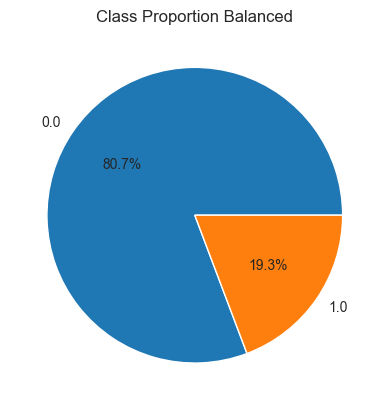

In [15]:
# Separate input features (X) and target variable (y)
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

# Plotting the class proportion
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion Balanced')
plt.show()

## Neural Network Model

* We first proceed by splitting the X_train and y_train into train and validation sets.

In [16]:
# ## DARREN APPROACH
# df_0, df_1 = new_dfx[new_dfx.order_ships == 0], new_dfx[new_dfx.order_ships == 1]
# df_0 = df_0.sample(n=len(df_1), random_state=2024)
# # df_1 = df_1.sample(n=(len(df_0)), replace=True)
# df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# # shuffle
# df_balanced = df_balanced.sample(frac=1)

# X_train = df_balanced.drop(columns='order_ships')
# y_train = df_balanced.order_ships
# X_test = new_dfx.drop(columns='order_ships')
# y_test = new_dfx.order_ships

## Our approach
# X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(df_final.drop(columns='order_ships'), 
#                                                                 df_final.order_ships, 
#                                                                 test_size=0.2,
#                                                                 stratify=y,
#                                                                 random_state=2024)

# # Getting the validation set
# X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn, 
#                                                               y_train_nn, 
#                                                               test_size=0.2,
#                                                               stratify=y_train_nn,
#                                                               random_state=2024)

# Getting the validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              stratify=y_train,
                                                              random_state=2024)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


* Then we compute the class weights in order to solve the unbalanced data problem while training our models

In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)

Class weights: {0: 0.6192491008699339, 1: 2.596451865684734}


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


#### Model Architecture and Approach 1 (Best one so far)

In [18]:
class F1Callback(Callback):
    def __init__(self, x_val, y_val):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x_val)
        f1 = f1_score(self.y_val, y_pred.round())
        if f1 > self.best_f1:
            self.best_f1 = f1
            print(f'Best F1 score: {f1}')

model_1 = Sequential([
    Dense(512, activation='relu', input_shape=(27,)),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(31, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    #Dropout(0.),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

# Compile the model_1
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class_weights = {0: 0.6192491008699339, 1: 2.596451865684734} 

f1_callback = F1Callback(X_val_nn, y_val_nn)

# Print the model_1 summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               14336     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [19]:
# Fit the model
history = model_1.fit(X_train_nn, y_train_nn, 
                    epochs=5, 
                    batch_size=128,
                    validation_data=(X_val_nn, y_val_nn),
                    class_weight=class_weights,)
#                    callbacks=[f1_callback])

Epoch 1/5


2024-03-17 12:00:04.556803: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8325/8325 [==============================] - 25s 3ms/step - loss: 0.5015 - accuracy: 0.7735 - val_loss: 0.4150 - val_accuracy: 0.8170
Epoch 2/5
8325/8325 [==============================] - 25s 3ms/step - loss: 0.3928 - accuracy: 0.8050 - val_loss: 0.3673 - val_accuracy: 0.8177
Epoch 3/5
8325/8325 [==============================] - 26s 3ms/step - loss: 0.3801 - accuracy: 0.8092 - val_loss: 0.3611 - val_accuracy: 0.8215
Epoch 4/5
8325/8325 [==============================] - 26s 3ms/step - loss: 0.3720 - accuracy: 0.8131 - val_loss: 0.3927 - val_accuracy: 0.8136
Epoch 5/5
8325/8325 [==============================] - 26s 3ms/step - loss: 0.3662 - accuracy: 0.8157 - val_loss: 0.3454 - val_accuracy: 0.8368


In [20]:
from sklearn.metrics import accuracy_score, f1_score

# Make predictions
predictions = model_1.predict(X_test)

# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, binary_predictions.reshape(-1))
print('Accuracy:', accuracy)

f1 = f1_score(y_test, binary_predictions.reshape(-1))
print('F1 Score:', f1)

10407/10407 [==============================] - 5s 467us/step
Accuracy: 0.8360976225011036
F1 Score: 0.677674822387187


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

## XGBoost Model

We can see that the class proportion is not balanced, but we are going to use the **scale_pos_weight** parameter in the XGBoost model in order to balance the classes. One quick rule of thumb to consider is that the scale_pos_weight should be equal to the ratio of the number of negative class to the positive class.

$$scale\_pos\_weight = \frac{negatives}{positives}$$

and therefore:

$$scale\_pos\_weight = \frac{negatives}{positives} = \frac{1344699}{320675} = 4.1933390504$$

### Hyperparameter Fine-Tuning Function For XGBoost

The next function is going to be used in order to fine-tune the hyperparameters of the XGBoost model by employing a strategy called Tree-structured Parzen Estimator (TPE). The TPE algorithm is a Bayesian optimization algorithm that explores the hyperparameter space efficiently.

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = f1_score(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

* Performing the hyperparameter optimization

In [23]:
# Hyperparameter space
options = {'max_depth': hp.quniform('max_depth', 1, 30, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 15),
           'reg_lambda': hp.uniform('reg_lambda', 1, 15),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
           'random_state': 2024,
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   early_stopping_rounds=30),
            space=options,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,#)
            timeout=60*20) # 20 minutos de tiempo de ejecución

best

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

  2%|▏         | 1/50 [00:39<32:12, 39.44s/trial, best loss: -0.5427735130060197]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

  4%|▍         | 2/50 [01:19<31:51, 39.82s/trial, best loss: -0.5890592360489406]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

  6%|▌         | 3/50 [03:42<1:08:07, 86.97s/trial, best loss: -0.5890592360489406]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

  8%|▊         | 4/50 [07:46<1:54:10, 148.93s/trial, best loss: -0.6958482404776422]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

 10%|█         | 5/50 [09:14<1:35:05, 126.80s/trial, best loss: -0.6958482404776422]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

 12%|█▏        | 6/50 [12:37<1:52:02, 152.79s/trial, best loss: -0.6958482404776422]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

 14%|█▍        | 7/50 [14:36<1:41:31, 141.67s/trial, best loss: -0.6958482404776422]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

 16%|█▌        | 8/50 [17:21<1:44:32, 149.35s/trial, best loss: -0.6976667858377827]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

 18%|█▊        | 9/50 [18:04<1:19:20, 116.10s/trial, best loss: -0.6976667858377827]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

 20%|██        | 10/50 [18:32<59:06, 88.65s/trial, best loss: -0.6976667858377827]  

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

 22%|██▏       | 11/50 [19:32<51:54, 79.86s/trial, best loss: -0.6976667858377827]

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

 24%|██▍       | 12/50 [23:51<1:15:32, 119.28s/trial, best loss: -0.6976667858377827]


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and w

{'colsample_bytree': 0.6255002487152117,
 'gamma': 0.9814344771546147,
 'learning_rate': 0.4230618658064805,
 'max_depth': 20.0,
 'min_child_weight': 13.169212729121458,
 'reg_alpha': 11.333374968608162,
 'reg_lambda': 14.377619941988252,
 'scale_pos_weight': 13.626760594113719,
 'subsample': 0.6838291470651824}

* These are the best hyperparameters for the XGBoost model (we saved them so that we don't have to run the optimization again). These are the parameters obtained with the new_dfx dataset.

In [24]:
best = {'colsample_bytree': 0.6255002487152117,
 'gamma': 0.9814344771546147,
 'learning_rate': 0.4230618658064805,
 'max_depth': 20.0,
 'min_child_weight': 13.169212729121458,
 'reg_alpha': 11.333374968608162,
 'reg_lambda': 14.377619941988252,
 'scale_pos_weight': 13.626760594113719,
 'subsample': 0.6838291470651824}

#best['random_state'] = 2024

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

Metrics : 


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

              precision    recall  f1-score   support

         0.0       0.98      0.82      0.90    268872
         1.0       0.56      0.93      0.70     64125

    accuracy                           0.84    332997
   macro avg       0.77      0.88      0.80    332997
weighted avg       0.90      0.84      0.86    332997



/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

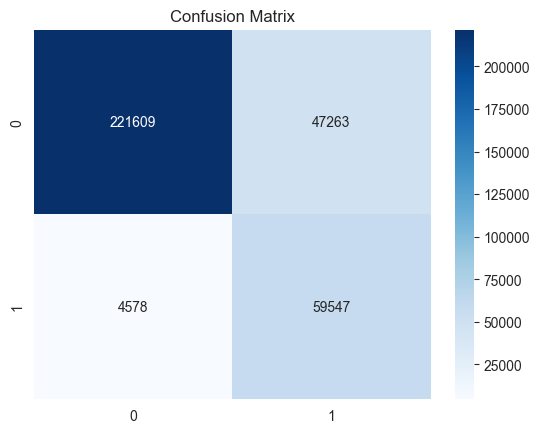

In [25]:
# Set the max_depth as an integer
best['max_depth'] = int(best['max_depth'])

# Train the model
xgb = XGBClassifier(**best,
                    n_estimators=100,
                    random_state = 2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Evaluate the model
print('Metrics : ')
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

Metrics : 
0.8443199187980672
0.6967209758095182


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

In [28]:
# y_test_2 = df_majoritie_excluded['order_ships'].to_numpy()
# X_test_2 = df_majoritie_excluded.drop(columns=['order_ships']).to_numpy()

# y_pred2 = xgb.predict(X_test_2)
# print(classification_report(y_test_2, y_pred2))
# sns.heatmap(confusion_matrix(y_test_2, y_pred2), annot=True, fmt='d', cmap='Blues')

### ROC Curve

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

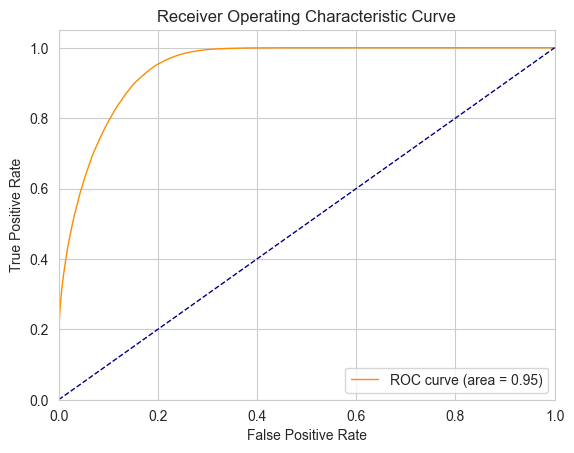

In [29]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

### Most Important Features

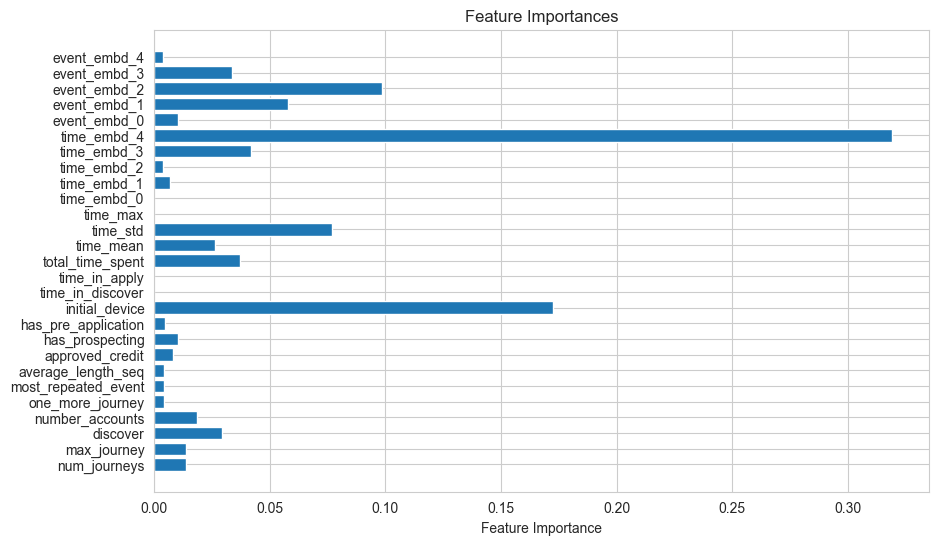

In [30]:
# Columns
x = list(df_final.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Cross Validation

For the original data set with the customers it takes approximately 12m 58s to run in my local machine.

In [35]:
X = pd.DataFrame(X, columns=new_dfx.drop(columns=['order_ships']).columns)
y = pd.DataFrame(y, columns=['order_ships'])

In [40]:
# Model
xgb = XGBClassifier(**best, 
                    n_estimators=100,
                    random_state = 2024)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

F1 Score: 0.6969127438746641
F1 Score: 0.0006597910684559127
Accuracy: 0.8446355578925757
Accuracy: 0.00047621019592134075


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

In [41]:
# Model
lr = LogisticRegression(max_iter=1000, random_state=2024)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

F1 Score: 0.38507926392097486
F1 Score: 0.0018436184497457183
Accuracy: 0.8293380944380966
Accuracy: 0.0004901906804439938


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

In [42]:
# Model
gnb = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

F1 Score: 0.5219755541852292
F1 Score: 0.0006556938017681612
Accuracy: 0.7093524173269896
Accuracy: 0.0043350893900499276


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Ensemble Model

* This took 9 mins without the SVC model

In [47]:
# create the individual models
clf1 = LogisticRegression(random_state=2024)
clf2 = RandomForestClassifier(random_state=2024)
clf3 = GaussianNB()
clf4 = XGBClassifier(**best, 
                     n_estimators=100,
                     random_state=2024)
clf5 = LGBMClassifier(random_state=2024)
clf6 = GradientBoostingClassifier(random_state=2024)
clf7 = AdaBoostClassifier(random_state=2024)
clf6 = DecisionTreeClassifier(random_state=2024)

# create the ensemble model
eclf = VotingClassifier(
    estimators=[('lr', clf1),
                ('rf', clf2),
                ('gnb', clf3),
                ('xgb', clf4),
                ('lgbm', clf5),
                ('gbc', clf6),
                ('abc', clf7),
                ('dtc', clf6),],
                #('nn', model_1)],
    voting='soft')

# fit the ensemble model
eclf = eclf.fit(X_train, y_train)

# make predictions
y_pred = eclf.predict(X_test)

# evaluate the ensemble model
print('Metrics : ')
print(classification_report(y_test, y_pred))

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

[LightGBM] [Info] Number of positive: 256501, number of negative: 1075485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3292
[LightGBM] [Info] Number of data points in the train set: 1331986, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192570 -> initscore=-1.433394
[LightGBM] [Info] Start training from score -1.433394


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

Metrics : 
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92    268871
         1.0       0.64      0.69      0.66     64125

    accuracy                           0.87    332996
   macro avg       0.78      0.80      0.79    332996
weighted avg       0.87      0.87      0.87    332996



/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

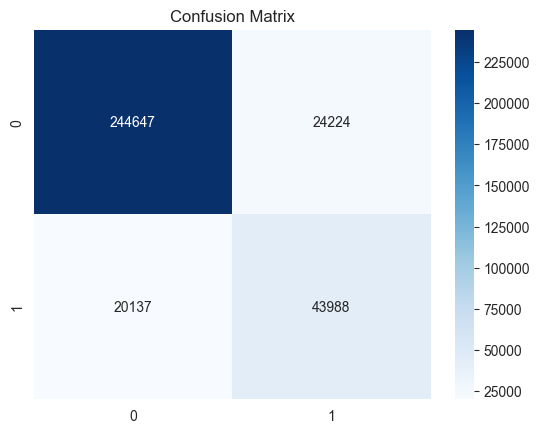

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [49]:
f1_score(y_test, y_pred)

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

0.6647876255317863

## Reporting Scores

These are the scores for the models that we have trained and tested. The following scores are the scores obtained while training the models with the original smaller_sample dataset.

### Original Small Sample Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.942110884782157,
 'gamma': 3.4881694516249135,
 'learning_rate': 0.12070560126724651,
 'max_depth': 16.0,
 'min_child_weight': 0.19649389479965745,
 'reg_alpha': 11.328885616312128,
 'reg_lambda': 11.414497321457764,
 'scale_pos_weight': 2.783520394913782,
 'subsample': 0.771213079559047}

* Metrics : 
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     13413
         1.0       0.57      0.83      0.67      3244



    accuracy                           0.84     16657

    macro avg       0.76      0.84      0.79     16657
   
    weighted avg       0.88      0.84      0.85     16657b

* Confussion Matrix : 

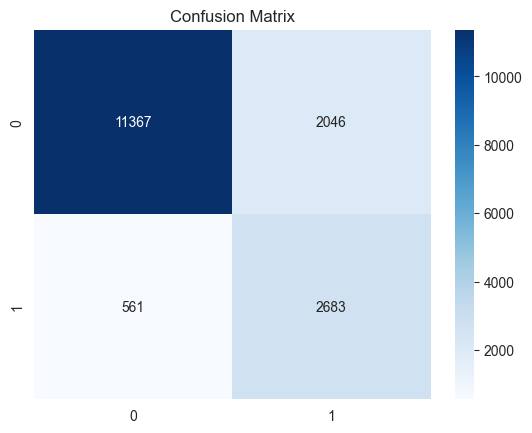


* CV (f1 score): XGBoost (500 estimators)
     * Mean : 0.6758662150237292
     * Std : 0.003472521869325704

### Upsampled Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.985209468525149,
 'gamma': 4.866388398218948e-05,
 'learning_rate': 0.0806777695575027,
 'max_depth': 22.0,
 'min_child_weight': 0.9682785419645363,
 'reg_alpha': 8.014544803174525,
 'reg_lambda': 1.040127534645051,
 'scale_pos_weight': 2.739947349919666,
 'subsample': 0.7884793754355912}

* Metrics : Metrics : 
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     13413
         1.0       0.53      0.87      0.66      3244

    accuracy                           0.83     16657

    macro avg       0.75      0.84      0.77     16657
   
    weighted avg       0.88      0.83      0.84     16657

* Confussion Matrix:

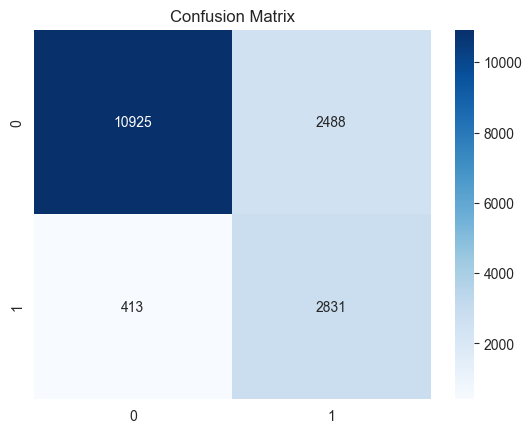

### Downsampling Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.8235873445603422,
 'gamma': 0.000128670224749042,
 'learning_rate': 0.17072875402514398,
 'max_depth': 14.0,
 'min_child_weight': 5.381336679960081,
 'reg_alpha': 9.187923998981237,
 'reg_lambda': 1.7522699976501133,
 'scale_pos_weight': 1.826877206585222,
 'subsample': 0.8790137193388823}

* Metrics : 
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83      3244
         1.0       0.79      0.95      0.86      3212

    accuracy                           0.84      6456
   macro avg       0.86      0.85      0.84      6456
weighted avg       0.86      0.84      0.84      6456

* Confussion Matrix:

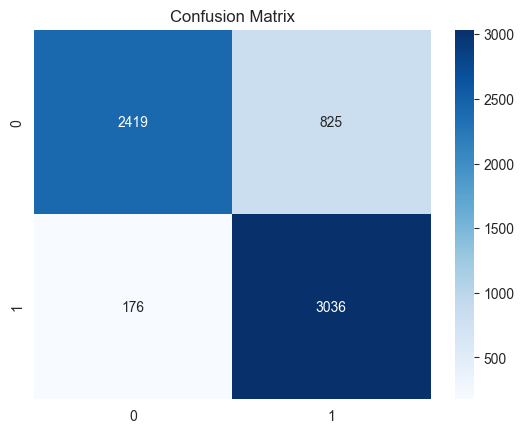

* Cross Validation : Mean F1 score :  0.8538944131112791, Std F1 :  0.004353035928353753

## Original proportion XGBOOST MODEL WITH THE UPDATED DATASET

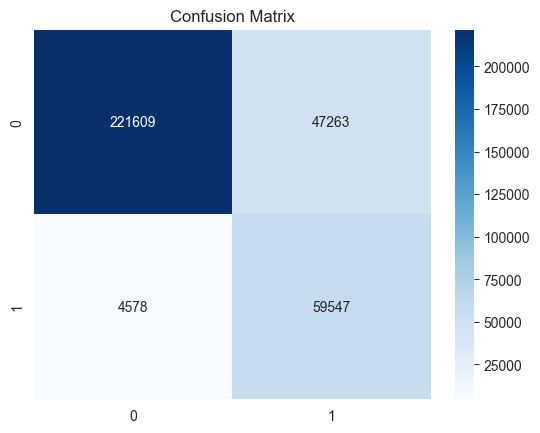